#Monkey Classification
The following project manage to build a Convolutional Neural Network that manage to classify 10 different species of monkey:
<br/><br/>


        
        
| Label | Latin Name            | Common Name               |
|-------|-----------------------|---------------------------|
| n0    | alouatta_palliata     | mantled_howler            |
| n1    | erythrocebus_patas    | patas_monkey              |
| n2    | cacajao_calvus        | bald_uakari               |
| n3    | macaca_fuscata        | japanese_macaque          |
| n4    | cebuella_pygmea       | pygmy_marmoset            |
| n5    | cebus_capucinus       | white_headed_capuchin     |
| n6    | mico_argentatus       | silvery_marmoset          |
| n7    | saimiri_sciureus      | common_squirrel_monkey    |
| n8    | aotus_nigriceps       | black_headed_night_monkey |
| n9    | trachypithecus_johnii | nilgiri_langur            |

###Download the dataset

Here I first download the datasetfrom kaggle to google drive, than I unzipped it.

NOTE: Run the following section only if you want to download the dataset from the original data source. if you are using the dataset provided on github skip this paragraph


In [ ]:
#!pwd

In [ ]:
#Start by connecting gdrive into the google colab
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#!pwd

In [ ]:
#%cd /content/drive/MyDrive/Knowledge_Discovery/CNN_Monkey_Classification/data

In [ ]:
#!pwd

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "*************" # username from the json file (kaggle API)
os.environ['KAGGLE_KEY'] = "****************" # key from the json file


In [ ]:
!kaggle datasets download -d slothkong/10-monkey-species

In [ ]:

# importing required modules
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "10-monkey-species.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
   
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')
'''

In [ ]:
#!rm 10-monkey-species.zip

## Make a custom dataset

In [ ]:
#pip install python-resize-image

In [ ]:
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
from resizeimage import resizeimage

In [ ]:
%cd /content/drive/MyDrive/Knowledge_Discovery/CNN_Monkey_Classification

/content/drive/MyDrive/Knowledge_Discovery/CNN_Monkey_Classification


In [ ]:
import os
dest_dir = "./data"
os.listdir(dest_dir)

['monkey_labels.txt', 'training', 'validation']

####Preprocessing
Resize, make squared and add a white background to the images 

NOTE: skip this section if you are using the dataset provided on github
These passages have been made before the dataset definition and haven't been added to the transformation in order to make the dataset easier to share

In [ ]:

def resize_img(folders): #add is a string to complete de path for the folders
  directory = os.path.join(dest_dir, folders)
  subfolders = sorted(os.listdir(directory))
  for folder in subfolders:
    path = os.path.join(directory, folder)  
    names = os.listdir(path)
    for name in names:
      image_path = os.path.join(path, name) 
      image = Image.open(image_path, mode="r")
      image_out = resizeimage.resize_contain(image,[224,224], bg_color=(255, 255, 255))
      image_out = image_out.convert('RGB')
      image_out.save(image_path)


In [ ]:
#convert the png image (only one in the whole dataset) into a jpg
image_path = os.path.join(dest_dir,"training/training","n9" , "n9160.png") 
image = Image.open(image_path, mode="r")
image_out = image.convert('RGB')
image_out.save( os.path.join(dest_dir,"training/training","n9" , "n9160.jpg"))
os.remove(image_path)

In [ ]:
resize_img("training/training")
resize_img("validation/validation")

###Dataset definition and uploading

In [ ]:
class MyMonkeyDataset(Dataset):
  def __init__(self, dset_dir, train=True, transforms=T.Compose([])):
    split = "training/training" if train else "validation/validation"
    self.dset_dir = Path(dset_dir)/split  
    self.transforms = transforms

    self.files = [] 

    folders = sorted(os.listdir(self.dset_dir)) 
    for folder in folders:
      class_idx = folders.index(folder)

      folder_dir = self.dset_dir/folder 

      files = os.listdir(folder_dir) 

      self.files += [{"file": folder_dir/x, "class": class_idx} for x in files]

  def __len__(self):
    return len(self.files)

  def __getitem__(self, i):
    item = self.files[i]
    file = item['file']
    class_idx = torch.tensor(item['class'])

    img = Image.open(file).convert("RGB")
    img = self.transforms(img)
    return img, class_idx

In [ ]:
# Compose transformations
transforms = T.Compose([                  
  T.ToTensor(),
  T.RandomHorizontalFlip(0.33),
  T.RandomVerticalFlip(0.33),
  T.Normalize(0.5, 0.5)
])

In [ ]:
train_dset = MyMonkeyDataset(dest_dir, train=True, transforms=transforms)
test_dset = MyMonkeyDataset(dest_dir, train=False, transforms=transforms)

In [ ]:
data,label = train_dset[1]
print(data.shape)

torch.Size([3, 224, 224])


In [ ]:
#check if the data transformation was successful for all the images
for i in range(0, len(test_dset)):
  data,label = test_dset[i]
  if data.shape != torch.Size([3, 224, 224]):
    print(data.shape)

####Creation of validation set

In [ ]:
# Dataset len
num_train = len(train_dset)
num_test = len(test_dset)
print(f"Num. training samples: {num_train}")
print(f"Num. test samples:     {num_test}")

Num. training samples: 1098
Num. test samples:     272


In [ ]:
# List of indexes on the training set
train_idx = list(range(num_train))
# List of indexes of the test set
test_idx = list(range(num_test))

In [ ]:
# Shuffle the training set
import random
random.seed(10)
random.shuffle(train_idx)
for i in range(10):
  print(train_idx[i])

631
920
641
662
192
1087
695
333
376
249


In [ ]:
# Fraction of the original train set that we want to use as validation set
val_frac = 0.1
# Number of samples of the validation set
num_val = int(num_train * val_frac) 
num_train = num_train - num_val

# Split training set
val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train] 

print(f"{num_train} samples used as train set")
print(f"{num_val}  samples used as val set")

989 samples used as train set
109  samples used as val set


In [ ]:
# Split train_dataset into training and validation
from torch.utils.data import Subset

val_dset = Subset(train_dset, val_idx)
train_dset = Subset(train_dset, train_idx)

In [ ]:
#ceck if the val_set is balanced in the classes ( if it's not, change the seed!)
zero = []
one = []
two = []
three =[]
four = []
five = []
six = []
seven = []
eight = []
nine = []

for x in range(0,num_val):
  if int(val_dset[x][1])==0: zero.append(x)
  if int(val_dset[x][1])==1: one.append(x)
  if int(val_dset[x][1])==2: two.append(x)
  if int(val_dset[x][1])==3: three.append(x) 
  if int(val_dset[x][1])==4: four.append(x) 
  if int(val_dset[x][1])==5: five.append(x) 
  if int(val_dset[x][1])==6: six.append(x) 
  if int(val_dset[x][1])==7: seven.append(x) 
  if int(val_dset[x][1])==8: eight.append(x) 
  if int(val_dset[x][1])==9: nine.append(x)

  print(len(zero), 
len(one),
len(two),
len(three),
len(four),
len(five),
len(six),
len(seven),
len(eight),
len(nine))

## Classification on Monkey

###Training function

In [ ]:
torch.cuda.is_available()

True

In [ ]:
dev = torch.device('cuda')
print(dev)

cuda


In [ ]:
def train(net, loaders, optimizer, criterion, epochs=20, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

###Model

In [ ]:
import torch.nn as nn

class MyMonkeyCNN(nn.Module):

  #Constructor
  def __init__(self, in_size=3, out_size=10, use_norm=False):
    # Call parent contructor
    super().__init__()
    self.layers = nn.Sequential(
      # Layer 1
      nn.Conv2d(in_channels=in_size, out_channels=64, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      # Layer 2
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Layer 3
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),      
      # Layer 4
      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
      nn.ReLU(),
      nn.AdaptiveMaxPool2d(output_size=2),
      # Classifier
      nn.Conv2d(in_channels=512, out_channels=out_size, kernel_size=2, padding=0, stride=1)
    )

  # Forward
  def forward(self, x):
    b, _, _, _ = x.shape
    output = self.layers(x)
    return output.view(b, -1)

In [ ]:
# Create the model
model = MyMonkeyCNN()
model

MyMonkeyCNN(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): AdaptiveMaxPool2d(output_size=2)
    (11): Conv2d(512, 10, kernel_size=(2, 2), stride=(1, 1))
  )
)

###Data Loader

In [ ]:
# Define loaders

train_loader = DataLoader(train_dset, batch_size=10, drop_last=True , shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dset,   batch_size=10, drop_last=False, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dset,  batch_size=10, drop_last=False, shuffle=False, num_workers=2)

In [ ]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

###Optimizer and Criterion

In [ ]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
# Define a loss 
criterion = nn.CrossEntropyLoss()

###Training

Epoch 1: TrL=2.2865, TrA=0.1347, VL=2.1863, VA=0.2404, TeL=2.1850, TeA=0.2714,
Epoch 2: TrL=2.0088, TrA=0.2673, VL=1.7264, VA=0.3040, TeL=1.7562, TeA=0.3357,
Epoch 3: TrL=1.7231, TrA=0.3786, VL=1.5480, VA=0.3495, TeL=1.5850, TeA=0.4250,
Epoch 4: TrL=1.5479, TrA=0.4367, VL=1.5361, VA=0.4040, TeL=1.5870, TeA=0.4464,
Epoch 5: TrL=1.4167, TrA=0.4908, VL=1.3778, VA=0.4758, TeL=1.3798, TeA=0.5286,
Epoch 6: TrL=1.3711, TrA=0.5112, VL=1.2901, VA=0.5687, TeL=1.3277, TeA=0.5286,
Epoch 7: TrL=1.2984, TrA=0.5398, VL=1.3296, VA=0.4960, TeL=1.3718, TeA=0.5214,
Epoch 8: TrL=1.1989, TrA=0.5816, VL=1.2061, VA=0.5606, TeL=1.2100, TeA=0.5964,
Epoch 9: TrL=1.1412, TrA=0.5857, VL=1.2335, VA=0.5576, TeL=1.2608, TeA=0.5464,
Epoch 10: TrL=1.1049, TrA=0.6235, VL=1.0623, VA=0.6778, TeL=1.1711, TeA=0.5786,
Epoch 11: TrL=1.0157, TrA=0.6347, VL=1.1919, VA=0.5960, TeL=1.1640, TeA=0.5607,
Epoch 12: TrL=1.0218, TrA=0.6531, VL=1.0179, VA=0.6505, TeL=1.0342, TeA=0.6179,
Epoch 13: TrL=0.9179, TrA=0.6949, VL=0.9695, VA=0

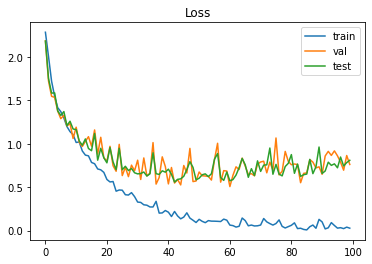

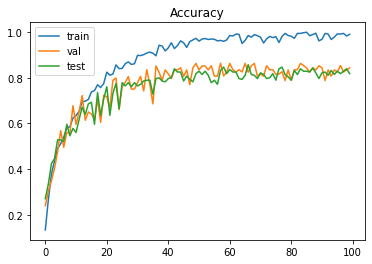

In [ ]:
# Train model
train(model, loaders, optimizer, criterion, epochs=100, dev=dev)

In [ ]:
#torch.cuda.empty_cache()